In [1]:
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Read and load Dataset 

In [2]:
import os 

dataset_slug = 'adl-project-deep-armocromia'
local_dataset_path = f'/kaggle/input/{dataset_slug}/release'

print(f'Dataset path: {local_dataset_path}')
print(f'Available folders: {os.listdir(local_dataset_path)}')

Dataset path: /kaggle/input/adl-project-deep-armocromia/release
Available folders: ['grok-chat.pdf', 'RGB', 'BM', 'RGB-M', 'annotations.csv']


In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

BASE_PATH = '/kaggle/input/adl-project-deep-armocromia/release/'

# Load labels (adjust path as needed)
annotations_df = pd.read_csv(os.path.join(BASE_PATH, 'annotations.csv'))  # Columns: image_path, season, subtype, skin_tone (e.g., 'warm'), etc.
display(annotations_df.head())
print(f"Dataset shape: {annotations_df.shape}")
# print(f"Season distribution:\n{labels_df['season'].value_counts()}")

season_map = {
    'primavera': 'Spring', 
    'estate': 'Summer', 
    'autunno': 'Autumn', 
    'inverno': 'Winter'
}
annotations_df['class'] = annotations_df['class'].str.lower().map(season_map)
annotations_df = annotations_df.rename(columns={
    'class': 'season',
})

print(annotations_df["partition"].unique())
print(annotations_df["sub_class"].unique())
print("\n\n ######## SEASONS AND CHARACTERISTICS (using groupby) ###############")
season_subclasses = annotations_df.groupby('season')['sub_class'].unique()
print(season_subclasses)

,class,sub_class,partition,celeba,path_rgb_original,path_rgb_masked,path_mask
0,autunno,deep,train,True,RGB/train/autunno/deep/10306.jpg,RGB-M/train/autunno/deep/10306.png,BM/train/autunno/deep/10306.png
1,autunno,deep,train,True,RGB/train/autunno/deep/10411.jpg,RGB-M/train/autunno/deep/10411.png,BM/train/autunno/deep/10411.png
2,autunno,deep,train,True,RGB/train/autunno/deep/10552.jpg,RGB-M/train/autunno/deep/10552.png,BM/train/autunno/deep/10552.png
3,autunno,deep,train,True,RGB/train/autunno/deep/11174.jpg,RGB-M/train/autunno/deep/11174.png,BM/train/autunno/deep/11174.png
4,autunno,deep,train,True,RGB/train/autunno/deep/11199.jpg,RGB-M/train/autunno/deep/11199.png,BM/train/autunno/deep/11199.png


Dataset shape: (4920, 7)
['train' 'test']
['deep' 'soft' 'warm' 'cool' 'light' 'bright']


 ######## SEASONS AND CHARACTERISTICS (using groupby) ###############
season
Autumn       [deep, soft, warm]
Spring    [bright, light, warm]
Summer      [cool, light, soft]
Winter     [bright, cool, deep]
Name: sub_class, dtype: object


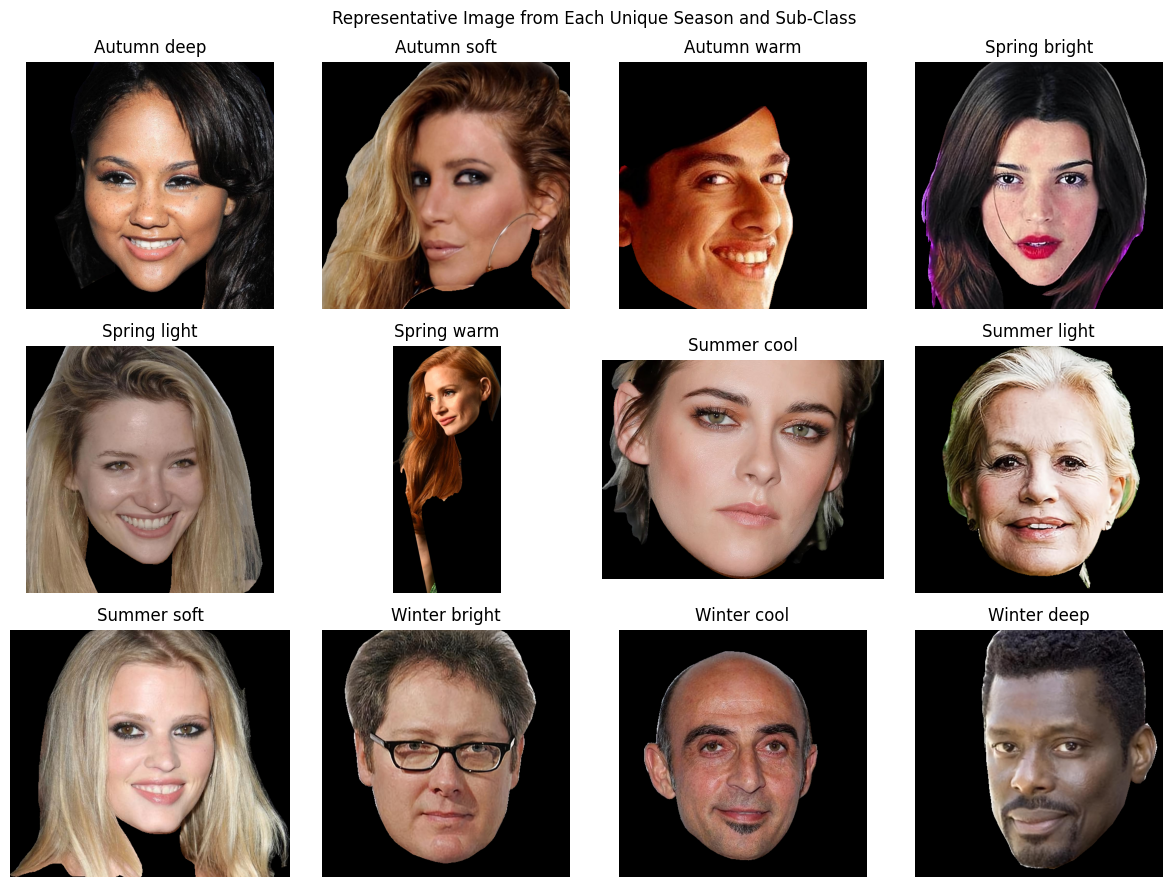

In [4]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# Identify unique categories
unique_categories = annotations_df.groupby(['season', 'sub_class']).size().reset_index(name='count')

# Grid of single images per category
n_categories = len(unique_categories)
n_cols = 4  # Adjust based on preference, max 4 for readability
n_rows = (n_categories + n_cols - 1) // n_cols  # Ceiling division for rows

plt.figure(figsize=(n_cols * 3, n_rows * 3))  # Adjust size based on grid

for i, (idx, row) in enumerate(unique_categories.iterrows(), 1):
    category_df = annotations_df[(annotations_df['season'] == row['season']) & (annotations_df['sub_class'] == row['sub_class'])]
    if len(category_df) == 0:
        print(f"No images found for {row['season']} {row['sub_class']}. Skipping.")
        continue
    sample = category_df.sample(1).iloc[0]
    img_path = os.path.join(BASE_PATH, sample['path_rgb_masked'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(img)
            plt.title(f"{row['season']} {row['sub_class']}")
            plt.axis('off')
        else:
            plt.subplot(n_rows, n_cols, i)
            plt.text(0.5, 0.5, 'Image Load Failed', ha='center', va='center')
            plt.axis('off')
    else:
        plt.subplot(n_rows, n_cols, i)
        plt.text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
        plt.axis('off')

plt.suptitle('Representative Image from Each Unique Season and Sub-Class')
plt.tight_layout()
plt.show()

# Prepare train and test Data

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.models import DenseNet121_Weights
import time

# Use 'season' directly as the label (4 classes: Autumn, Spring, Summer, Winter)
# Get unique seasons and map to indices
unique_seasons = annotations_df['season'].unique()
season_to_idx = {season: idx for idx, season in enumerate(sorted(unique_seasons))}
num_classes = len(unique_seasons)
print(f"Number of classes: {num_classes}")
print(f"Classes: {sorted(unique_seasons)}")

# Assign season indices
annotations_df['season_idx'] = annotations_df['season'].map(season_to_idx)

# Custom Dataset Class with One-Hot Encoding for seasons
class ArmocromiaDataset(Dataset):
    def __init__(self, df, base_path, transform=None, partition=None):
        if partition:
            self.df = df[df['partition'] == partition].reset_index(drop=True)
        else:
            self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.transform = transform
        self.num_classes = len(df['season'].unique())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['path_rgb_masked'])  # Use masked for skin focus
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = Image.open(img_path).convert('RGB')
        season_idx = row['season_idx']
        if self.transform:
            image = self.transform(image)
        # Convert season_idx to one-hot encoding
        one_hot_label = torch.zeros(self.num_classes)
        one_hot_label[season_idx] = 1
        return image, one_hot_label

# Image transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

partitions = annotations_df['partition'].unique()
print(f"Available partitions: {partitions}")

# Create datasets
train_df = annotations_df[annotations_df['partition'] == 'train']
test_df = annotations_df[annotations_df['partition'] == 'test']

train_dataset = ArmocromiaDataset(train_df, BASE_PATH, transform=train_transform)
test_dataset = ArmocromiaDataset(test_df, BASE_PATH, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

Number of classes: 4
Classes: ['Autumn', 'Spring', 'Summer', 'Winter']
Available partitions: ['train' 'test']


# build model 

In [7]:
# Load DenseNet-121 with default pre-trained weights
model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
print("Successfully loaded pre-trained weights for DenseNet-121.")

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Modify the final classifier layer with dropout for 4 seasons
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Loss and optimizer with weight decay
# Check season distribution for class weights
season_counts = annotations_df['season'].value_counts()
total_samples = len(annotations_df)
class_weights = torch.FloatTensor([total_samples / (len(season_counts) * count) for count in season_counts.sort_index().values]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-3)  # Higher LR for fine-tuning classifier

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01, save_path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)

    def save_checkpoint(self, val_loss, model):
        print(f"Validation loss decreased ({self.best_loss:.4f} --> {val_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), self.save_path)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 216MB/s]


Successfully loaded pre-trained weights for DenseNet-121.


In [11]:
# ============================= TWO-STAGE FINE-TUNING =============================
# Stage 1: Train only classifier (already done) → now unfreeze backbone
print("Unfreezing backbone layers for fine-tuning...")
for name, param in model.named_parameters():
    if "features.denseblock3" in name or "features.denseblock4" in name:
        param.requires_grad = True  # Unfreeze last two dense blocks
    else:
        param.requires_grad = False

# Higher LR for backbone, lower for classifier
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},  # Very small LR
    {'params': model.classifier.parameters(), 'lr': 1e-4}  # Slightly higher
], weight_decay=1e-3)

# patience
early_stopping = EarlyStopping(patience=10, min_delta=0.001, save_path='best_model_finetune.pth')

# augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Re-create train dataset with augmentations
train_dataset = ArmocromiaDataset(train_df, BASE_PATH, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Re-compute class weights (important!)
from collections import Counter
season_counts = Counter(train_df['season'])
class_weights = torch.FloatTensor([
    1.0 / season_counts[season] for season in sorted(unique_seasons)
]).to(device)
class_weights = class_weights / class_weights.sum() * len(unique_seasons)  # Normalize
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ============================= FINE-TUNING LOOP =============================
num_epochs = 50
best_val_acc = 0.0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, one_hot_labels in train_loader:
        images = images.to(device)
        one_hot_labels = one_hot_labels.to(device)
        labels = torch.argmax(one_hot_labels, dim=1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (pred == labels).sum().item()

    train_acc = 100.0 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct_top1 = 0
    val_correct_top2 = 0
    val_total = 0

    with torch.no_grad():
        for images, one_hot_labels in test_loader:
            images = images.to(device)
            one_hot_labels = one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Top-1
            _, pred_top1 = torch.max(outputs, 1)
            val_correct_top1 += (pred_top1 == labels).sum().item()

            # Top-2
            _, pred_top2 = torch.topk(outputs, 2, dim=1)
            val_correct_top2 += sum([1 if labels[i] in pred_top2[i] else 0
                                    for i in range(labels.size(0))])

            val_total += labels.size(0)

    val_top1 = 100.0 * val_correct_top1 / val_total
    val_top2 = 100.0 * val_correct_top2 / val_total
    avg_val_loss = val_loss / len(test_loader)

    # --- Print ---
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {avg_val_loss:.4f}")
    print(f"  Val Top-1: {val_top1:.2f}% | Val Top-2: {val_top2:.2f}%")

    # --- Save best ---
    if val_top1 > best_val_acc:
        best_val_acc = val_top1
        torch.save(model.state_dict(), 'best_model_finetune.pth')
        print(f"  New best Val Top-1: {val_top1:.2f}% → Model saved!")

    # --- Early stopping ---
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Load best fine-tuned model
model.load_state_dict(torch.load('best_model_finetune.pth'))
model.eval()

# ============================= FINAL TEST (per-class) =============================
test_correct_top1 = 0
test_correct_top2 = 0
test_total = 0
class_correct = torch.zeros(num_classes, dtype=torch.float)
class_total   = torch.zeros(num_classes, dtype=torch.float)

with torch.no_grad():
    for images, one_hot_labels in test_loader:
        images = images.to(device)
        one_hot_labels = one_hot_labels.to(device)
        labels = torch.argmax(one_hot_labels, dim=1)

        outputs = model(images)

        # Top-1 & Top-2
        _, pred_top1 = torch.max(outputs, 1)
        test_correct_top1 += (pred_top1 == labels).sum().item()
        _, pred_top2 = torch.topk(outputs, 2, dim=1)
        test_correct_top2 += sum([1 if labels[i] in pred_top2[i] else 0
                                 for i in range(labels.size(0))])

        # Per-class
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            class_correct[label] += (pred_top1[i] == label).item()

        test_total += labels.size(0)

test_top1 = 100.0 * test_correct_top1 / test_total
test_top2 = 100.0 * test_correct_top2 / test_total

print(f"\n=== FINAL TEST (FINE-TUNED) ===")
print(f"Test Top-1: {test_top1:.2f}% | Test Top-2: {test_top2:.2f}%")
print("Per-class accuracy:")
for i, season in enumerate(sorted(unique_seasons)):
    acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"  {season:7s} : {acc:5.2f}%  ({int(class_correct[i])}/{int(class_total[i])})")

Unfreezing backbone layers for fine-tuning...
Epoch [1/50]
  Train Loss: 1.1741 | Train Acc: 47.03%
  Val   Loss: 1.0867
  Val Top-1: 52.63% | Val Top-2: 80.37%
  New best Val Top-1: 52.63% → Model saved!
Validation loss decreased (1.0867 --> 1.0867). Saving model...
Epoch [2/50]
  Train Loss: 1.1542 | Train Acc: 49.33%
  Val   Loss: 1.1000
  Val Top-1: 52.19% | Val Top-2: 80.15%
EarlyStopping counter: 1 out of 10
Epoch [3/50]
  Train Loss: 1.1354 | Train Acc: 49.40%
  Val   Loss: 1.0690
  Val Top-1: 53.84% | Val Top-2: 81.25%
  New best Val Top-1: 53.84% → Model saved!
Validation loss decreased (1.0690 --> 1.0690). Saving model...
Epoch [4/50]
  Train Loss: 1.1073 | Train Acc: 49.90%
  Val   Loss: 1.0673
  Val Top-1: 53.51% | Val Top-2: 81.69%
Validation loss decreased (1.0673 --> 1.0673). Saving model...
Epoch [5/50]
  Train Loss: 1.0801 | Train Acc: 53.39%
  Val   Loss: 1.0570
  Val Top-1: 52.74% | Val Top-2: 82.02%
Validation loss decreased (1.0570 --> 1.0570). Saving model...
Epoc